In [1]:
!git clone https://github.com/microsoft/otdd/

Cloning into 'otdd'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 120 (delta 24), reused 17 (delta 17), pack-reused 89
Receiving objects: 100% (120/120), 92.47 KiB | 2.80 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [2]:
%pip install -r otdd/requirements.txt

  Cloning https://github.com/jeanfeydy/geomloss to /tmp/pip-req-build-fjhlb6v1
  Running command git clone --filter=blob:none --quiet https://github.com/jeanfeydy/geomloss /tmp/pip-req-build-fjhlb6v1
  Resolved https://github.com/jeanfeydy/geomloss to commit 5804ca57f84bd95226efd1d44929022deb9cd23a
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/rossant/ipycache to /tmp/pip-req-build-k7zjvx2_
  Running command git clone --filter=blob:none --quiet https://github.com/rossant/ipycache /tmp/pip-req-build-k7zjvx2_
  Resolved https://github.com/rossant/ipycache to commit 906d8ee9e201ab2bc4029fd4d47d4bff5bb64b52
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.0/790.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
'''
change distance.py => line 322-323 to:
self.classes1 = self.V1
self.classes2 = self.V2
'''

'\nchange distance.py => line 322-323 to:\nself.classes1 = self.V1\nself.classes2 = self.V2\n'

In [36]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [41]:
dataset = "house_prices"
label = "label"

sims = list(np.round(np.arange(0, 1, 0.1), 2))
MAX_SAMPLES = 600

In [42]:
def gen_synth_label_random(y, tr):
    lb = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if np.random.random() > tr:
            lb[i] = int(np.random.random() > 0.5)
        else:
            lb[i] = y[i]
    return lb


In [43]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, thresh, transform=None, label_cols=[""], label=""):
        df = pd.read_csv(csv_file).iloc[:MAX_SAMPLES, :]
        self.data = torch.FloatTensor(df.drop(label_cols, axis=1).values)
        self.transform = transform
        self.targets = torch.Tensor(df[label])
        self.classes = ['0', '1']
        self.indices = np.arange(df.shape[0])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx, :]
        if self.transform:
            sample = self.transform(sample)

        return sample, self.targets[idx]

In [44]:
from otdd.otdd.pytorch.distance import DatasetDistance

csv_file_path = f'./sample_data/cleaned_data_{dataset}_ground_truth.csv'

label_cols = ['label']

agrs = []
dists = []
trs = []

tr = 0


dataset_1_gt = CustomDataset(csv_file_path, tr, label_cols=label_cols, label='label')

for i in range(len(sims)):
    csv_file_path_sim = f'./sample_data/cleaned_data_{dataset}_with_sim_{sims[i]}.csv'
    dataset_2_sm = CustomDataset(csv_file_path_sim, tr, label_cols=label_cols, label='label')

    agr = (dataset_1_gt.targets == dataset_2_sm.targets).numpy().mean()
    print("% Agreement", agr)

    dist = DatasetDistance(dataset_1_gt, dataset_2_sm,
                        inner_ot_method = 'exact',
                        debiased_loss = False,
                        p = 2, entreg = 1e-1,
                        device='cpu')

    d = dist.distance(maxsamples=MAX_SAMPLES)
    print(sims[i], f'OTDD(src,tgt)={d}')

    agrs.append(agr)
    dists.append(d)

% Agreement 0.5133333333333333


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0.0 OTDD(src,tgt)=2029.330322265625
% Agreement 0.5583333333333333


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0.1 OTDD(src,tgt)=1965.08447265625
% Agreement 0.5933333333333334


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0.2 OTDD(src,tgt)=1877.9296875
% Agreement 0.6516666666666666


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0.3 OTDD(src,tgt)=1839.957275390625
% Agreement 0.6866666666666666


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0.4 OTDD(src,tgt)=2174.9384765625
% Agreement 0.725


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0.5 OTDD(src,tgt)=1902.594482421875
% Agreement 0.8066666666666666


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0.6 OTDD(src,tgt)=1749.1434326171875
% Agreement 0.8366666666666667


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0.7 OTDD(src,tgt)=1810.49267578125
% Agreement 0.9016666666666666


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0.8 OTDD(src,tgt)=1775.1728515625
% Agreement 0.9516666666666667


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0.9 OTDD(src,tgt)=1815.558837890625


In [15]:
# from otdd.otdd.pytorch.distance import DatasetDistance

# csv_file_path = f'./sample_data/cleaned_data_{dataset}_with_sim_labels.csv'
# label_cols = [f'label_sim_{round(x, 2)}' for x in sims] + ['label_ground_truth']

# agrs = []
# dists = []
# trs = []

# tr = 0


# dataset_1_gt = CustomDataset(csv_file_path, tr, label_cols=label_cols, label='label_ground_truth')

# for i in range(len(sims)):
#     dataset_2_sm = CustomDataset(csv_file_path, tr, label_cols=label_cols, label=label_cols[i])

#     agr = (dataset_1_gt.targets == dataset_2_sm.targets).numpy().mean()
#     print("% Agreement", agr)

#     dist = DatasetDistance(dataset_1_gt, dataset_2_sm,
#                         inner_ot_method = 'exact',
#                         debiased_loss = False,
#                         p = 2, entreg = 1e-1,
#                         device='cpu')

#     d = dist.distance(maxsamples=MAX_SAMPLES)
#     print(sims[i], f'OTDD(src,tgt)={d}')

#     agrs.append(agr)
#     dists.append(d)

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
from scipy.stats import pearsonr
corr = pearsonr(sims, dists)

In [47]:
corr

PearsonRResult(statistic=-0.5805035829592619, pvalue=0.07848913687834674)

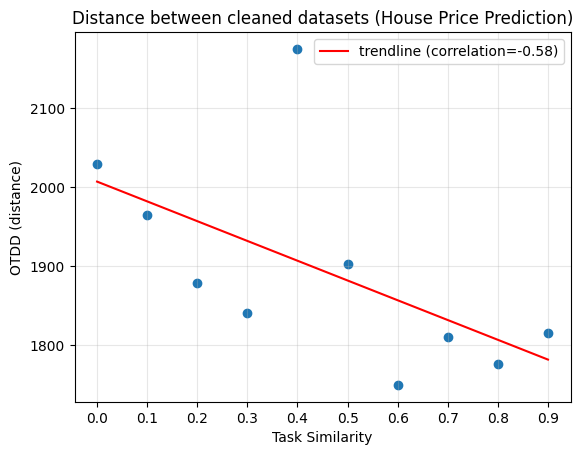

<Figure size 640x480 with 0 Axes>

In [48]:
plt.scatter(sims, dists, marker='o')

z = np.polyfit(sims, dists, 1)
p = np.poly1d(z)

plt.plot(sims, p(sims), color='red', label=f'trendline (correlation={round(corr.statistic, 2)})')

plt.xticks(np.arange(0, 1, 0.1))

plt.xlabel("Task Similarity")
plt.ylabel("OTDD (distance)")

plt.grid(alpha=0.3)
plt.legend()
plt.title("Distance between cleaned datasets (House Price Prediction)")

plt.show()

plt.savefig('house_prices_dataset_distance.png', dpi=200)